# Developing a Classifier for Movie Rating for IMDB Data Set

## Section 0: Load Dependencies and Data

In [37]:
import pandas as pd  # For data manipulation and analysis
from collections import Counter  # For counting hashable objects
from sklearn.decomposition import PCA  # For dimensionality reduction
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualization
from sklearn.feature_selection import mutual_info_classif  # For feature importance estimation
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.svm import SVC  # Support Vector Classifier for SVM
from sklearn.model_selection import KFold  # For k-fold cross-validation
import statistics as stat  # For statistical calculations
from sklearn.preprocessing import StandardScaler  # For standardizing features
from sklearn.cross_decomposition import PLSRegression  # Partial Least Squares regression
from sklearn.metrics import r2_score  # For calculating R-squared metric
import random  # For generating random numbers
from sklearn.model_selection import GridSearchCV  # For hyperparameter optimization
from sklearn.neighbors import KNeighborsClassifier  # k-Nearest Neighbors classifier

# Loading the datasets for training and testing
try:
    Test = pd.read_csv('project_data/test_dataset.csv')  # Test dataset
    Train = pd.read_csv('project_data/train_dataset.csv')  # Training dataset
    print("Datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure the file paths are correct.")
    raise
except pd.errors.EmptyDataError as e:
    print(f"Error: {e}. Ensure the CSV files are not empty.")
    raise
except Exception as e:
    print(f"An unexpected error occurred while loading datasets: {e}")
    raise



# Validating the datasets
def validate_dataset(df, name):
    print(f"\nValidating {name} dataset:")
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("Warning: Missing values detected.")
        print(missing_values[missing_values > 0])
    else:
        print("No missing values detected.")
    
    # Check for duplicate rows
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"Warning: {duplicate_count} duplicate rows found.")
    else:
        print("No duplicate rows detected.")
    
    # Check for feature consistency
    print("Dataset shape:", df.shape)
    if df.empty:
        print(f"Error: {name} dataset is empty.")
        raise ValueError(f"{name} dataset is empty.")
    elif len(df.columns) == 0:
        print(f"Error: {name} dataset has no columns.")
        raise ValueError(f"{name} dataset has no columns.")
    else:
        print(f"{name} dataset structure is valid.")
    
    # Display basic statistics for numeric columns
    print("Basic statistics:")
    print(df.describe())

# Validate both Train and Test datasets
validate_dataset(Train, "Training")
validate_dataset(Test, "Testing")

print("\nValidation complete.")


Datasets loaded successfully!

Validating Training dataset:
language    1
dtype: int64
No duplicate rows detected.
Dataset shape: (3004, 27)
Training dataset structure is valid.
Basic statistics:
               id  num_critic_for_reviews     duration  \
count  3004.00000             3004.000000  3004.000000   
mean   1502.50000              165.609188   110.076565   
std     867.32443              121.254549    21.910608   
min       1.00000                2.000000    37.000000   
25%     751.75000               76.000000    96.000000   
50%    1502.50000              137.000000   106.000000   
75%    2253.25000              223.000000   120.000000   
max    3004.00000              813.000000   330.000000   

       director_facebook_likes  actor_3_facebook_likes  \
count              3004.000000             3004.000000   
mean                778.890146              767.860186   
std                2990.741946             1901.991202   
min                   0.000000                0.0

## Section 1: Pre-processing, and exploratory analysis

### 1.1: Analyzing Genre Distribution and Frequency

In [38]:
# Split the "genres" column into a list of genres for each movie
Train["genres"] = Train["genres"].apply(lambda x: x.split("|"))

# Initialize an empty list to store all genre occurrences
genreFreqList = []

# Flatten the nested list of genres to prepare for frequency calculation
for genres in Train["genres"]:
    for genre in genres:
        genreFreqList.append(genre)

# Count the occurrences of each genre using Counter
count = Counter(genreFreqList)
print("Genre Frequency Count:", count)  # Output the genre frequency count
print("Number of unique genres:", len(count))  # Output the number of unique genres

# Function to one-hot encode genres for each row
def OneHotEncodeGenre(row):
    """
    Updates the row's genre columns with one-hot encoding.
    Each genre column value is incremented by 1 if the genre is present in the row.

    Parameters:
    row (Series): A row of the DataFrame containing a list of genres.

    Returns:
    Series: Updated row with one-hot encoded genre columns.
    """
    for genre in row["genres"]:  # Iterate over genres in the current row
        row[genre] += 1  # Increment the respective genre column
    return row

# Get the list of unique genres as column labels
labels = list(count.keys())

# Create a DataFrame with one column per genre, initialized to 0
EncodedGenres = pd.DataFrame(0, index=np.arange(len(Train)), columns=labels)

# Copy the "genres" column from the original Train dataset to preserve genre lists
EncodedGenres["genres"] = Train["genres"].copy(deep=True)

print("Initial one-hot encoded DataFrame (before processing):")
print(EncodedGenres)

# Apply the one-hot encoding function to each row of the DataFrame
EncodedGenres = EncodedGenres.apply(lambda x: OneHotEncodeGenre(x), axis=1)

# Drop the now-unnecessary "genres" column as the data has been encoded
EncodedGenres = EncodedGenres.drop(columns=["genres"])

# Output the final one-hot encoded DataFrame
print("Final one-hot encoded DataFrame (after processing):")
print(EncodedGenres)


Genre Frequency Count: Counter({'Drama': 1505, 'Comedy': 1175, 'Thriller': 884, 'Action': 765, 'Romance': 699, 'Adventure': 612, 'Crime': 568, 'Fantasy': 405, 'Sci-Fi': 388, 'Family': 354, 'Horror': 321, 'Mystery': 306, 'Biography': 194, 'Animation': 146, 'War': 127, 'Music': 126, 'History': 125, 'Sport': 114, 'Musical': 79, 'Western': 41, 'Documentary': 37, 'Film-Noir': 1})
Number of unique genres: 22
Initial one-hot encoded DataFrame (before processing):
      Adventure  Animation  Drama  Family  Musical  Horror  Mystery  Sci-Fi  \
0             0          0      0       0        0       0        0       0   
1             0          0      0       0        0       0        0       0   
2             0          0      0       0        0       0        0       0   
3             0          0      0       0        0       0        0       0   
4             0          0      0       0        0       0        0       0   
...         ...        ...    ...     ...      ...     ...      .

### 1.4 Load embeddings

In [39]:
KWEembeddings  = np.load("project_data/features_doc2vec/features_doc2vec/train_doc2vec_features_plot_keywords.npy")
Gembeddings = np.load("project_data/features_doc2vec/features_doc2vec/train_doc2vec_features_genre.npy")
Tembeddings = np.load("project_data/features_fasttext/features_fasttext/train_fasttext_title_embeddings.npy")

KeyWordEmbeddings = pd.DataFrame(KWEembeddings)
GenreEmbeddings = pd.DataFrame(Gembeddings)
TitleEmbeddings = pd.DataFrame(Tembeddings)

### 1.3 PCA over key words

[0.01397617 0.01367059 0.01338739 0.01320896 0.01312078 0.01300149
 0.01292323 0.01288995 0.01270434 0.0126465  0.01250464 0.01247992
 0.0124291  0.01235408 0.01220273 0.01216494 0.01209563 0.01200051
 0.01194723 0.01187871 0.0117927  0.01170355 0.01162331 0.01156426
 0.01147942 0.01144798 0.01132168 0.01131157 0.01127319 0.01113881
 0.01108392 0.01103914 0.01093972 0.01087448 0.01076942 0.01073094
 0.01070977 0.01062587 0.01059772 0.01053451 0.01051691 0.01037897
 0.01034229 0.01026397 0.01022264 0.01020866 0.01011693 0.0100693
 0.01001463 0.00989678 0.00988039 0.00982888 0.00977755 0.00967461
 0.00959246 0.00955949 0.00952878 0.00947307 0.00945353 0.0093838
 0.00932673 0.00922166 0.00909375 0.0090723  0.00905445 0.00899118
 0.00897093 0.00891371 0.00882784 0.00878735 0.00876076 0.0086878
 0.00860488 0.00850369 0.00846597 0.00845264 0.00835308 0.00826296
 0.00823666 0.00818917 0.00816796 0.00808119 0.00795243 0.00792693
 0.00790657 0.00784829 0.00781607 0.00769733 0.00763074 0.0075990

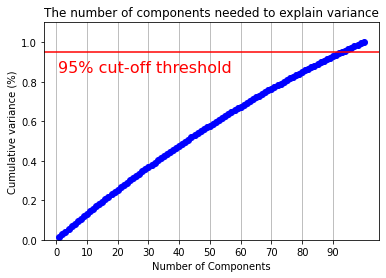

In [40]:
pca = PCA()
pca.fit(KeyWordEmbeddings)

print(pca.explained_variance_ratio_)


plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 101, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 100, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### 1.5 PCA and MI over title embeddings

[0.         0.00323553 0.00043153 0.00956551 0.00082238 0.01532995
 0.00785553 0.00772514 0.00115445 0.01126045 0.00532958 0.00189026
 0.         0.00855685 0.01946228 0.02647774 0.00465644 0.00343097
 0.00056887 0.00523408 0.03021029 0.01006745 0.00229827 0.
 0.02669065 0.         0.00650274 0.01362896 0.01471979 0.02457737
 0.         0.01879296 0.         0.01683522 0.         0.01686168
 0.0193818  0.         0.01301412 0.01770906 0.01036057 0.01673082
 0.01268001 0.01469227 0.02761664 0.02124814 0.01665444 0.00861722
 0.         0.00786161 0.03214245 0.00512466 0.         0.
 0.01051197 0.00728574 0.0054488  0.00016415 0.01620285 0.01090512
 0.02384988 0.02059718 0.00729989 0.02668568 0.         0.00949239
 0.00611889 0.02166585 0.01433278 0.00713529 0.02039322 0.01015921
 0.01303125 0.01593818 0.02412025 0.00582146 0.         0.01505634
 0.00151585 0.02482412 0.01829345 0.01594238 0.         0.01143285
 0.01301603 0.02431513 0.01336973 0.00291292 0.02254995 0.01121823
 0.01064826

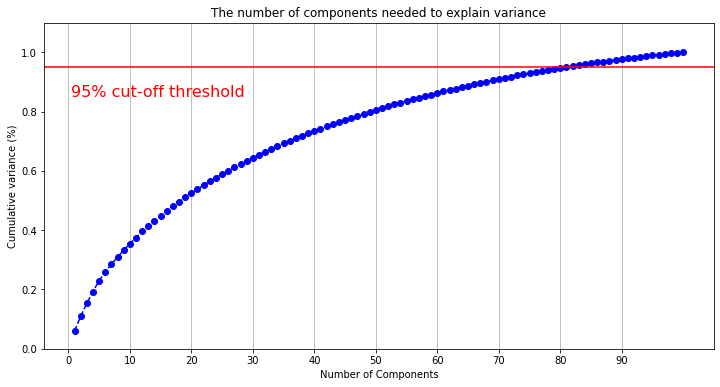

In [41]:
print(mutual_info_classif(TitleEmbeddings,Train["imdb_score_binned"]))
print('\n\n\n')

pca = PCA()
pca.fit(GenreEmbeddings)

print(pca.explained_variance_ratio_)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 101, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 100, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### 1.6 encode rating

In [42]:
ratings = Train["content_rating"]

ratingsFreqList = []

for i in Train["content_rating"]:
    ratingsFreqList.append(i)

#print(genreFreqList)
count = Counter(ratingsFreqList)
print(count)

#1 G approved GP passed ✅
#2 PG or pg 13 or anything with 13 ✅
#3 M, not rated, unrated
#4 R
#5 X or NC 17
def convertRatings(row):
    if 'pg' in row.lower() or '13' in row.lower(): 
        return 2
    if row.lower() == 'g' or row.lower() == 'gp' or row.lower() == "passed":
        return 1
    if 'M' in row.lower() or row.lower() == "no rated" or row.lower() == "unrated":
        return 3
    if row.lower() == "r":
        return 4
    if row.lower() == "x" or "NC" in row.lower():
        return 5
    return 3

ratings = ratings.apply(lambda x: convertRatings(x))


Counter({'R': 1362, 'PG-13': 1039, 'PG': 458, 'G': 68, 'Not Rated': 27, 'Unrated': 19, 'Approved': 14, 'X': 9, 'NC-17': 3, 'M': 2, 'Passed': 2, 'GP': 1})


### 1.7 encode country

In [43]:
#get frequencies of countries
countryFreqList = []
for i in Train["country"]:
    countryFreqList.append(i)
count = Counter(countryFreqList)
print(count)


cont = Train["country"]
sub_region = pd.DataFrame("BLANK", index=np.arange(len(cont)), columns=["sub_region", "continent"]) 
cont = pd.concat([cont,sub_region],axis=1)

#load datra set in for match to sub_region and continent
countryTable = pd.read_csv("C:/Users/HAWal/Desktop/Machine learning Proj 2/contToreg.csv")



def getRegion(row):
    val = countryTable.loc[countryTable["country"] == row["country"]]
    if len(val) == 0:
        row["sub_region"] = "Northern America"
        row["continent"] = "Americas"
        return row
    row["sub_region"] = val.iloc[0]["sub_region"]
    row["continent"] = val.iloc[0]["continent"]
    return row
cont = cont.apply(lambda x: getRegion(x),axis=1)


def OneHotEncodeSingleCot(row):
    row[row["continent"]] += 1
    return row

continentFreqList = []
for value in cont["continent"]:
    continentFreqList.append(value)
count2 = Counter(continentFreqList)
print(count2)



labels = list(count2.keys())
EncodedCont = pd.DataFrame(0, index=np.arange(len(Train)), columns=labels) 
EncodedCont["continent"] = cont["continent"].copy(deep=True)
EncodedCont = EncodedCont.apply(lambda x: OneHotEncodeSingleCot(x), axis=1)

EncodedCont = EncodedCont.drop(columns=["continent"])



Counter({'USA': 2382, 'UK': 255, 'France': 86, 'Germany': 61, 'Canada': 46, 'Australia': 32, 'Spain': 21, 'Japan': 12, 'New Zealand': 10, 'China': 9, 'Hong Kong': 9, 'Italy': 8, 'South Korea': 7, 'Denmark': 6, 'Mexico': 6, 'Ireland': 6, 'Brazil': 4, 'India': 3, 'Thailand': 3, 'Norway': 3, 'South Africa': 3, 'Netherlands': 3, 'Argentina': 3, 'Iran': 3, 'Hungary': 2, 'Romania': 2, 'Russia': 2, 'Czech Republic': 2, 'Taiwan': 2, 'Chile': 1, 'Afghanistan': 1, 'Israel': 1, 'Colombia': 1, 'West Germany': 1, 'Official site': 1, 'Aruba': 1, 'Finland': 1, 'Iceland': 1, 'Poland': 1, 'Belgium': 1, 'New Line': 1, 'Indonesia': 1})


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/HAWal/Desktop/Machine learning Proj 2/contToreg.csv'

### 1.8 Logistic Regression for choosing embeddings or encoding for genre

In [26]:
numericColumnSet = ['num_critic_for_reviews','duration','director_facebook_likes','actor_3_facebook_likes','actor_1_facebook_likes','gross','num_voted_users','cast_total_facebook_likes','facenumber_in_poster','num_user_for_reviews','title_year','actor_2_facebook_likes','movie_facebook_likes','average_degree_centrality']

PreTotalData = pd.concat([Train[numericColumnSet],EncodedCont,ratings], axis = 1)
PreTotalData.columns = PreTotalData.columns.astype(str)

TotalData = pd.concat([Train[numericColumnSet],EncodedCont,ratings,TitleEmbeddings,KeyWordEmbeddings], axis = 1)
TotalData.columns = TotalData.columns.astype(str)
TotalDataPlusGenreEmbeddings = pd.concat([TotalData,GenreEmbeddings],axis=1)
TotalDataPlusGenreEmbeddings.columns = TotalDataPlusGenreEmbeddings.columns.astype(str)
TotalDataPlusGenreEncodings = pd.concat([TotalData,EncodedGenres],axis=1)
TotalDataPlusGenreEncodings.columns = TotalDataPlusGenreEncodings.columns.astype(str)

scaler = StandardScaler()
S_TotalData = scaler.fit_transform(PreTotalData)
S_TotalData = pd.DataFrame(S_TotalData)
S_TotalData.columns = PreTotalData.columns

c = scaler.fit_transform(TotalDataPlusGenreEmbeddings)
S_TotalDataPlusGenreEncoding = pd.DataFrame(c)
S_TotalDataPlusGenreEncoding.columns = TotalDataPlusGenreEmbeddings.columns


In [ ]:
def pls_explained_variance(pls, X, Y_true, do_plot=True):
    r2 = np.zeros(pls.n_components)
    x_transformed = pls.transform(X) # Project X into low dimensional basis
    for i in range(0, pls.n_components):
        Y_pred = (np.dot(x_transformed[:, i][:, np.newaxis],
                         pls.y_loadings_[:, i][:, np.newaxis].T) * pls._y_std   
                  + pls._y_mean)
        r2[i] = r2_score(Y_true, Y_pred)
        overall_r2 = r2_score(Y_true, pls.predict(X))  # Use all components together.

    if do_plot:
        component = np.arange(pls.n_components) + 1
        plt.plot(component, r2, '.-')
        plt.xticks(component)
        plt.xlabel('PLS Component #'), plt.ylabel('r2')
        plt.title(f'Summed individual r2: {np.sum(r2):.3f}, '
                  f'Overall r2: {overall_r2:.3f}')
        plt.show()

    return r2, overall_r2

pls = PLSRegression(n_components=len(TotalDataPlusGenreEmbeddings.columns)-1,max_iter=2500)
pls.fit(TotalDataPlusGenreEmbeddings,Train["imdb_score_binned"])

#RSq, TotalRsq = pls_explained_variance(pls,S_TotalDataPlusGenreEncoding,Train["imdb_score_binned"], do_plot=True)

prev = 0
pls = PLSRegression(n_components=len(TotalDataPlusGenreEmbeddings.columns)-1,max_iter=1000000)
pls.fit(TotalDataPlusGenreEmbeddings, Train["imdb_score_binned"])
temp = pls.transform(TotalDataPlusGenreEmbeddings)

tempList = []
for i in range(1,len(TotalDataPlusGenreEmbeddings.columns)):
    Itemp = temp[:,i-1]
    Jtemp = Train["imdb_score_binned"].to_numpy()
    tempList.append(np.abs(np.cov(Itemp,Jtemp)[1,0]))



import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(TotalDataPlusGenreEmbeddings.columns), step=1)
y = np.cumsum(tempList)/sum(tempList)

plt.ylim(0.0,1.1)
plt.plot(xi, y,marker = 'o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(TotalDataPlusGenreEmbeddings.columns), step=25)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.vlines(10,0,1.2)
plt.show()




In [ ]:



clf = LogisticRegression(max_iter=100000)
CVSmodel = SVC()
kf = KFold(n_splits=2)
for i in [TotalData,TotalDataPlusGenreEncodings,TotalDataPlusGenreEmbeddings]:
    avgScore = []
    for j, (train_index, test_index) in enumerate(kf.split(i)):
        X = i.iloc[train_index]
        Y = Train.iloc[train_index]["imdb_score_binned"]
        Xt = i.iloc[test_index]
        Yt = Train.iloc[test_index]["imdb_score_binned"]
        clf.fit(X,Y)
        avgScore.append(clf.score(Xt,Yt))
    print("Score of Dataset: ", stat.mean(avgScore))

# 0.660125138427464
# 0.6607785160575859
# 0.6464518272425249

### 1.9 feature selection using ablation approach

In [ ]:
def accuracy_SVM(X,Y,Xt,Yt):
    clf = SVC()
    clf.fit(X,Y)
    return clf.score(Xt,Yt)

def accuracy_Logistic(X,Y,Xt,Yt):
    clf = LogisticRegression(max_iter=100000,random_state=1273213)
    clf.fit(X,Y)
    return clf.score(Xt,Yt)

def AIC_Logistic(X,Y,Xt,Yt):
    clf = LogisticRegression(max_iter=100000,random_state=1273213)
    clf.fit(X,Y)
    return 2*len(X) - 2*clf.predict_log_proba(Xt)

random.seed = 10023913
### pass entire data set
### test FULL model, get AIC
### remove each column and score model, get AIC score for each removal
### get lowest AIC score, remove column
### repeat until no features have positive AIC score
### generalise for AIC, Accuracy, and BIC

def ablationFeatureSelection(fullDataSet,TestSet,scoreFunc,MaxOrMin,nSplits,threshold = False):
    featureDict = {} #store the score for each removed feature
    columnIndex = {} #index for each column
    iter = 0
    kf = KFold(n_splits=nSplits,random_state=10201331,shuffle=True) 
    for series_name, series in fullDataSet.items():
        columnIndex[iter] = series_name
        iter += 1


    avgScr = []
    for j, (train_index, test_index) in enumerate(kf.split(fullDataSet)):
        X = fullDataSet.iloc[train_index]
        Y = TestSet.iloc[train_index]
        Xt = fullDataSet.iloc[test_index]
        Yt = TestSet.iloc[test_index]
        avgScr.append(scoreFunc(X,Y,Xt,Yt))
    print("baseline:", stat.mean(avgScr))

    ###iterate over feature set
    for i in range(fullDataSet.shape[1]):
        targetFeatureName = columnIndex[i]
        FeatureSet = fullDataSet.drop(columns=[targetFeatureName],axis=1)
        avgScr = []
        for j, (train_index, test_index) in enumerate(kf.split(FeatureSet)):
            X = FeatureSet.iloc[train_index]
            Y = TestSet.iloc[train_index]
            Xt = FeatureSet.iloc[test_index]
            Yt = TestSet.iloc[test_index]

            avgScr.append(scoreFunc(X,Y,Xt,Yt))
        featureDict[targetFeatureName] = stat.mean(avgScr)

    #get either the lowest or highest outcome or maybe outcomes
    if (MaxOrMin == 'maxamise'):
        maxval = max(featureDict.values())
        badColumns = list(filter(lambda x: featureDict[x]==maxval, featureDict))
    else:
        minval = min(featureDict.values())
        badColumns = list(filter(lambda x: featureDict[x]==minval, featureDict))
    
    return random.choice(badColumns), featureDict[random.choice(badColumns)]

### curr feature set goes in
###
###

def buildUp(currFeatureSet,fullDataSet,TestSet,scoreFunc,MaxOrMin,nSplits,threshold = False):
    featureDict = {} #store the score for each removed feature
    columnIndex = {} #index for each column
    iter = 0
    kf = KFold(n_splits=nSplits,random_state=10201331,shuffle=True) 
    for series_name, series in fullDataSet.items():
        columnIndex[iter] = series_name
        iter += 1

    for i in range(fullDataSet.shape[1]-len(currFeatureSet)):
        targetFeatureName = columnIndex[i]
        if (targetFeatureName in currFeatureSet):
            break
        combo = currFeatureSet + [targetFeatureName]
        FeatureSet = fullDataSet[combo]
        avgScr = []
        for j, (train_index, test_index) in enumerate(kf.split(FeatureSet)):
            X = FeatureSet.iloc[train_index]
            Y = TestSet.iloc[train_index]
            Xt = FeatureSet.iloc[test_index]
            Yt = TestSet.iloc[test_index]

            avgScr.append(scoreFunc(X,Y,Xt,Yt))
        featureDict[targetFeatureName] = stat.mean(avgScr)

    if (MaxOrMin == 'maxamise'):
        maxval = max(featureDict.values())
        badColumns = list(filter(lambda x: featureDict[x]==maxval, featureDict))
    else:
        minval = min(featureDict.values())
        badColumns = list(filter(lambda x: featureDict[x]==minval, featureDict))
    
    return random.choice(badColumns), featureDict[random.choice(badColumns)]



ablationAttempt = S_TotalDataPlusGenreEncoding.copy(deep=True)
currFeat = []
baseLineAccuracy = 0
while (1):
    columnName, accuracy = buildUp(currFeat, ablationAttempt,Train["imdb_score_binned"],accuracy_Logistic,'maxamise',25)
    if (accuracy < baseLineAccuracy):
        break
    print(columnName, " , ", accuracy)
    currFeat.append(columnName)
    print("current combo: ",currFeat)
    baseLineAccuracy = accuracy

'''
while len(ablationAttempt.columns) > 1:
    print(len(ablationAttempt.columns))
    columnName,accuracy = ablationFeatureSelection(ablationAttempt, Train["imdb_score_binned"],accuracy_Logistic,'maxamise',2,)
    if (accuracy < baseline):
        break
    print(columnName, " , ", accuracy)
    ablationAttempt.drop(columns=[columnName],inplace=True,axis=1)
    baseline = accuracy
'''




### 2.1 Model on PLS outcome

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
kf = KFold(n_splits=5,random_state=10201331,shuffle=True) 

avgScr = []
for j, (train_index, test_index) in enumerate(kf.split(temp)):
    X = temp[train_index,0:11]
    Y = Train["imdb_score_binned"].iloc[train_index]
    Xt = temp[test_index,0:11]
    Yt = Train["imdb_score_binned"].iloc[test_index]
    clf = LogisticRegression(max_iter=100000)
    clf.fit(X,Y)
    avgScr.append(clf.score(Xt,Yt))
print(stat.mean(avgScr))

### 2.2 Grid search over

In [ ]:


params = [{'max_depth': range(20,100,20),'n_estimators':range(50,500,75),'criterion':[ "gini", "entropy", "log_loss"]} ]

RF = RandomForestClassifier(random_state=10000)

gs_RandomForest = GridSearchCV(RF,
                               param_grid=params,
                               scoring='accuracy',
                               cv=4,
                               verbose=3)
gs_RandomForest.fit(S_TotalData, Train["imdb_score_binned"])
print(gs_RandomForest.best_params_, gs_RandomForest.best_score_)

### 2.3 grid search over entire non-pls dataset

In [ ]:
params = [{'max_depth': [25,50,75,100],'n_estimators':[100,300,500],'criterion':[ "gini", "entropy"]} ]

RF = RandomForestClassifier(random_state=10000)

gs_RandomForest = GridSearchCV(RF,
                               param_grid=params,
                               scoring='accuracy',
                               cv=3,
                               verbose=3)
gs_RandomForest.fit(S_TotalDataPlusGenreEncoding, Train["imdb_score_binned"])
print(gs_RandomForest.best_params_, gs_RandomForest.best_score_)

### neural network

In [ ]:

import sys
print (sys.path)
sys.path.append("/Users/HAWal/AppData/Roaming/Python/Python311/Scripts")
print (sys.path)

import torch
import torch.nn.functional as F
import torch.utils.data as dataUtils

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from collections import Counter

import matplotlib.pyplot as plt

import time


class NeuralNetwork(torch.nn.Module):
    def __init__(self, nInputs, l1, l2, l3, nClasses):
        super(NeuralNetwork, self).__init__()
        self.Numerical = torch.nn.Sequential(
            torch.nn.Linear(20, 10),
            torch.nn.Sigmoid(),
            torch.nn.Linear(10,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings1 = torch.nn.Sequential(
            torch.nn.Linear(100, 20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings2 = torch.nn.Sequential(
            torch.nn.Linear(100,20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Embeddings3 = torch.nn.Sequential(
            torch.nn.Linear(100,20),
            torch.nn.Sigmoid(),
            torch.nn.Linear(20,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25)
        )
        self.Combination = torch.nn.Sequential(
            torch.nn.Linear(40,10),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(p=0.25),
            torch.nn.Linear(10,nClasses),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        a = self.Numerical(x[:,0:20])
        b = self.Embeddings1(x[:,20:120])
        c = self.Embeddings2(x[:,120:220])
        d = self.Embeddings3(x[:,220:320])
        combined = torch.cat((a,b,c,d), dim=1)
        out = self.Combination(combined)
        return out

def test(model, criterion, test_loader):
    test_loss = 0.
    test_preds, test_labels = list(), list()
    for i, data in enumerate(test_loader):
        x, labels = data

        with torch.no_grad():
            logits = model(x)
            predictions = torch.argmax(logits, dim=1)
            test_loss += criterion(input=logits, target=labels).item()
            test_preds.append(predictions)
            test_labels.append(labels)

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_accuracy = torch.eq(test_preds, test_labels).float().mean().item()

    print('[TEST] Mean loss {:.4f} | Accuracy {:.4f}'.format(test_loss/len(test_loader), test_accuracy))


def train(model, train_loader, test_loader, optimizer, n_epochs=10):
    LOG_INTERVAL = 250
    running_loss, running_accuracy = list(), list()
    start_time = time.time()
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epochs):

        epoch_loss = 0.

        for i, data in enumerate(train_loader):

            x, labels = data

            logits = model(x)

            predictions = torch.argmax(logits, dim=1)
            train_acc = torch.mean(torch.eq(predictions, labels).float()).item()

            loss = criterion(input=logits, target=labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss.append(loss.item())
            running_accuracy.append(train_acc)

            epoch_loss += loss.item()

            if i % LOG_INTERVAL == 0:
                deltaT = time.time() - start_time
                mean_loss = epoch_loss / (i+1)
                print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f} | Train accuracy {:.5f} | Time {:.2f} s'.format(epoch, 
                    i, len(train_loader), mean_loss, train_acc, deltaT))

        print('Epoch complete! Mean loss: {:.4f}'.format(epoch_loss/len(train_loader)))

        test(model, criterion, test_loader)
    return running_loss, running_accuracy


xTrain, xTest, yTrain, yTest = train_test_split(TotalDataPlusGenreEmbeddings, Train["imdb_score_binned"], test_size=0.2, random_state=981488)

xTrain = torch.tensor(xTrain.values, dtype=torch.float)
yTrain = torch.tensor(yTrain.values).type(torch.LongTensor)
trainData = dataUtils.TensorDataset(xTrain, yTrain)
trainLoader = dataUtils.DataLoader(trainData, batch_size=128, shuffle=True)

xTest = torch.tensor(xTest.values, dtype=torch.float)
yTest = torch.tensor(yTest.values).type(torch.LongTensor)
testData = dataUtils.TensorDataset(xTest, yTest)
testLoader = dataUtils.DataLoader(testData, batch_size=128, shuffle=False)

neuralNetwork = NeuralNetwork(len(TotalDataPlusGenreEmbeddings.columns), 150, 100, 50, 5)

optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=1e-2, momentum=0.5)

nnLoss, nnAcc = train(neuralNetwork, trainLoader, testLoader, optimizer, 100)

plt.plot(nnLoss)
plt.xlabel("iterations")
plt.ylabel("Cross-entropy Loss (Train)")
plt.show()

plt.plot(nnAcc)
plt.xlabel("iterations")
plt.ylabel("Accuracy (Train)")
plt.show()